In [129]:

### Classic VAE
###
############################################################

from __future__ import print_function
import h5py as h5
import numpy as np
import numba
import sklearn
import tensorflow as tf

print ("Numpy      ver. ", np.__version__)
print ("Numba      ver. ", numba.__version__)  ##  optimize numpy?!?
print ("H5Py       ver. ", h5.__version__)
print ("SKLearn    ver. ", sklearn.__version__)
print ("TensorFlow ver. ", tf.__version__)

import matplotlib
#matplotlib.use('agg')             ## Need for CMD
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

tf.reset_default_graph()

from tensorflow.python.client import device_lib
print( [ x.name for x in device_lib.list_local_devices() ] )


Numpy      ver.  1.15.4
Numba      ver.  0.41.0
H5Py       ver.  2.7.1
SKLearn    ver.  0.19.2
TensorFlow ver.  1.12.0
[u'/device:CPU:0', u'/device:XLA_GPU:0', u'/device:XLA_CPU:0', u'/device:GPU:0', u'/device:GPU:1']


In [132]:
#### Load waveform data

H5_FILE="white_h_8192_dm2.h5"
RATE=8192
H5_FILE="white_h_4096_dm2.h5"
RATE=4096

#!wget http://grqc.ncts.ncku.edu.tw/~lincy/GWDA/white_h_4096_dm2.h5
#!ls


# of whiten waveform for each set:  685


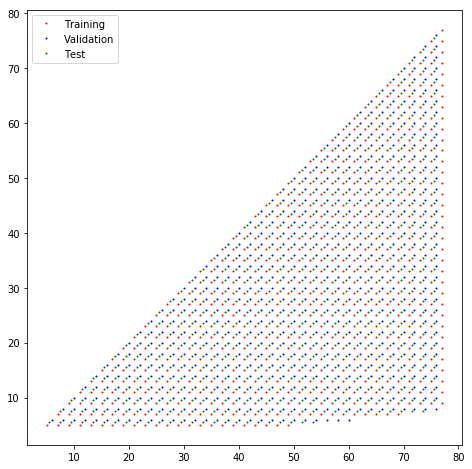

In [133]:
#### Now, visualize the dataset 
import h5py as h5
import matplotlib.pyplot as plt
%matplotlib inline

f = h5.File(H5_FILE,'r')
m1t = f['train_m1']
m2t = f['train_m2']
m1v = f['val_m1']
m2v = f['val_m2']
m1s = f['test_m1']
m2s = f['test_m2']

plt.figure(figsize=(8,8))
plt.plot(m2t, m1t, 'r.', markersize=2, label="Training")
plt.plot(m2v, m1v, 'b.', markersize=2, label="Validation")
plt.plot(m2s, m1s, 'g.', markersize=2, label="Test")
plt.axes().set_aspect('equal')
plt.legend()
#plt.show()
#plt.savefig("VAE_tpl.png")

print ("# of whiten waveform for each set: ", len(f['train_hp']))

f.close()

4096 0.66


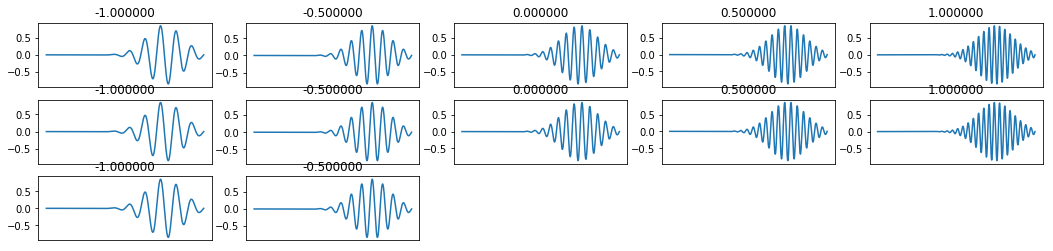

In [119]:
###
###  Prepare data: extract, transform, load (ETL)
###
import time
#from datetime import datetime
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

####  EDIT HERE ####
NTYPE = 4     ### Number of toy data type.
z_dim = 4     ### latent neuron
y_dim = 2     ### constraint neuron
h_dim = 512

TBOARD = False

####################

_NOISE_COPY_ = 1
class GWInject():
    def _add_noise(self, tag, A, nc):
        var = self.f[tag]
        NX = len(var)
        NN = nc * NX
        noise = np.random.normal(0,1,(NN,self.srate))    
        X     = np.random.normal(0,1,(NX,self.srate))  + A * var[:NX,:]      
        if self.plot:
            plt.figure(figsize=(18,6))
            for i in range(len(X)):
                plt.subplot(3,5,i+1)         
                plt.plot(X[i,:])
                plt.plot(A * var[i,:])
                #plt.title(" )
                if (i > 13): break
            plt.show()

        X = np.vstack( (noise, X )  ).astype(np.float32)
        Y = np.array([0]*NN + [1]*NX).astype(np.float32).reshape(-1,1)
        #return shuffle(X, Y, random_state=0)
        return X, Y
    
    def __init__(self, fname, plot=0):
        self.fname = fname
        self.plot = plot
        self.f = h5.File(fname, "r")
        self.srate = self.f.attrs.get('srate')   ##4096/ 8192
        print(self.srate, self.f.attrs.get('merger_idx'))
        
    def __exit__(self):
        self.f.close()
        
    def get_train_set(self, A=1.0, nc = _NOISE_COPY_):
        X, Y = self._add_noise('/train_hp', A, nc = nc)
        return X, Y
    def get_val_set(self, A=1.0, nc = _NOISE_COPY_):
        X, Y = self._add_noise('/val_hp', A, nc = nc)
        return X, Y
    def get_test_set(self, A=1.0):
        X, Y = self._add_noise('/test_hp', A, nc = _NOISE_COPY_)
        return X, Y
      
    def getdata(self, tag='/train', A=1.0):
        X1 = A*np.array(self.f[tag+'_hp'])  #.astype(np.float32)
        X2 = A*np.array(self.f[tag+'_hc'])  #.astype(np.float32)
        
        Y  = np.vstack(( self.f[tag+'_m1'],self.f[tag+'_m2'] )).astype(np.float32)
        print (np.max(Y))
        Y  = (Y / 80. -0.5)*2
        
        if self.plot:
            plt.figure(figsize=(18,6))
            for i in range(len(X1)):
                plt.subplot(3,5,i+1)         
                plt.plot(X1[i,:])
                plt.title("m=(%.1f, %.1f)"%(Y[0,i],Y[1,i]))
                plt.xticks([])
                if (i > 13): break
            plt.show()
            
        return X1,X2,np.transpose(Y)
        #return np.hstack((X1, X2)), Y

    ###  reduced set of GW    
    def getdata2(self, tag='/train', A=1.0):
        SKIP=40
        X1 = A*np.array(self.f[tag+'_hp'][::SKIP,])  #.astype(np.float32)
        X2 = A*np.array(self.f[tag+'_hc'][::SKIP,])  #.astype(np.float32)
        
        #Mt = np.array(self.f[tag+'_m1']) + np.array(self.f[tag+'_m2'])
        #Mq = np.array(self.f[tag+'_m1'])*np.array(self.f[tag+'_m2']) / Mt        
        #Mt = ( (Mt - np.min(Mt))/ (np.max(Mt) - np.min(Mt)) -0.5 ) *2
        #Mq = ( (Mq - np.min(Mq))/ (np.max(Mq) - np.min(Mq)) -0.5 ) *2
        #Y  = np.vstack(( Mt[::SKIP], Mq[::SKIP] )).astype(np.float32)
        
        Y  = np.vstack(( self.f[tag+'_m1'][::SKIP], self.f[tag+'_m2'][::SKIP] )).astype(np.float32)
        Y  = (Y / 80. -0.5)*2
        
        X1 = np.tile( X1, (SKIP,1) )
        X2 = np.tile( X2, (SKIP,1) )
        Y =  np.tile( Y,  (1, SKIP) )
        
        if self.plot:
            plt.figure(figsize=(18,6))
            for i in range(len(X1)):
                plt.subplot(3,5,i+1)         
                plt.plot(X1[i,:])
                plt.title("m=(%.1f, %.1f)"%(Y[0,i],Y[1,i]))
                plt.xticks([])
                if (i > 13): break
            plt.show()
            
        return X1,X2,np.transpose(Y)
        #return np.hstack((X1, X2)), Y
    
    def get_toydata(self, A=1.0):  ##sin
        x = np.linspace(0,2*np.pi,RATE)
        y = np.tile( np.linspace(0,2*np.pi,NTYPE+1)[:-1] , 250)
        xx, yy = np.meshgrid(x, y, sparse=True)
        X1 = A*(np.sin(xx - yy))
        X2 = A*(np.cos(xx - yy))     #.astype(np.float32)
        
        #ynor = y / np.max(y)   ## normalize
        ynor = ( y / np.max(y) - 0.5 ) *2   ## normalize
        
        Y  = np.vstack(( ynor, ynor )).astype(np.float32)
        
        if self.plot:
            plt.figure(figsize=(18,4))
            for i in range(0,len(X1)):
                idx=i
                plt.subplot(3,NTYPE,i+1)         
                plt.plot(X1[idx,:])
                plt.title("%f"%(Y[0,idx]))
                plt.xticks([])
                if (i > NTYPE*2): break
            plt.show()
            
        return X1,X2,np.transpose(Y)

    def get_toydata2(self, A=1.0):  ##sin-gaussian
        x = np.linspace(0,2*np.pi,RATE)
        y = np.tile( np.linspace(10,30,NTYPE)[:] , 20)
        xx, yy = np.meshgrid(x, y, sparse=True)
        X1 = A*(np.sin(yy*xx)*np.exp(-(xx-1.5*np.pi)**2))
        X2 = A*(np.cos(yy*xx)*np.exp(-(xx-1.5*np.pi)**2))     #.astype(np.float32)
        
        #ynor = y / np.max(y)   ## normalize
        ynor = ( (y-np.min(y)) / (np.max(y)-np.min(y)) - 0.5 ) *2   ## normalize
        
        Y  = np.vstack(( ynor, ynor )).astype(np.float32)
        
        if self.plot:
            plt.figure(figsize=(18,4))
            for i in range(0,len(X1)):
                idx=i
                plt.subplot(3,NTYPE,i+1)         
                plt.plot(X1[idx,:])
                plt.title("%f"%(Y[0,idx]))
                plt.xticks([])
                if (i > NTYPE*2): break
            plt.show()
            
        return X1,X2,np.transpose(Y)
    
tmp = GWInject(H5_FILE, plot=1)
AMP = 0.87
#X,Y,_ = tmp.getdata2('/train', A=AMP)  
X,Y,_ = tmp.get_toydata2(A=AMP)  
#print(X.shape)
#tmp.__exit__()

In [120]:
###
### Prepare data 
###
tmp = GWInject(H5_FILE, plot=0)
#Xt,Xt2,Yt = tmp.getdata2('/train', A=AMP)  
#Xv,Xv2,Yv = tmp.getdata2('/val', A=AMP)  
#Xs,Xs2,Ys = tmp.getdata2('/test', A=AMP)  
Xt,Xt2,Yt = tmp.get_toydata2(A=AMP)  
Xv,Xv2,Yv = tmp.get_toydata2(A=AMP)  
Xs,Xs2,Ys = tmp.get_toydata2(A=AMP)  

#Xt = np.reshape( np.hstack((Xt1,Xt2)), (-1, CH[0], RATE) )
#Xv = np.reshape( np.hstack((Xv1,Xv2)), (-1, CH[0], RATE) )
#Xs = np.reshape( np.hstack((Xs1,Xs2)), (-1, CH[0], RATE) )

print (Xt.shape)
print (Xv.shape)
print (Xs.shape)
print (Yt.shape)
print (Yv.shape)
print (Ys.shape)

print( np.min(Xv[10:11,:]), np.max(Xv[10:11,:]) )


4096 0.66
(100, 4096)
(100, 4096)
(100, 4096)
(100, 2)
(100, 2)
(100, 2)
-0.8491920937795132 0.8492055358903904


In [121]:
###############
###############   Original VAE
###############
tf.reset_default_graph()

RATE = 4096

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


# =============================== Q(z|X) : proposed encoder ======================================
X  = tf.placeholder(tf.float32, shape=[None, RATE])
c  = tf.placeholder(tf.float32, shape=[None, y_dim])
z  = tf.placeholder(tf.float32, shape=[None, z_dim])
lr = tf.placeholder(tf.float32, shape=[])

## 
Q_W1 = tf.Variable(xavier_init([RATE + y_dim, h_dim]), name="Q_W1")
Q_b1 = tf.Variable(xavier_init([h_dim]), name="Q_b1")    #Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]), name="Q_b1")
##
Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]), name="Q_W2_mu")
Q_b2_mu = tf.Variable(xavier_init([z_dim]), name="Q_b2_mu")         #Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]), name="Q_b2_mu")
Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]), name="Q_W2_sigma")
Q_b2_sigma = tf.Variable(xavier_init([z_dim]), name="Q_b2_sigma")   #Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]), name="Q_b2_sigma")

if TBOARD: 
    tf.summary.histogram('Q_W1', Q_W1)
    tf.summary.histogram('Q_b1', Q_b1)
    tf.summary.histogram('Q_W2_mu', Q_W2_mu)
    tf.summary.histogram('Q_b2_mu', Q_b2_mu)
    tf.summary.histogram('Q_W2_sigma', Q_W2_sigma)
    tf.summary.histogram('Q_b2_sigma', Q_b2_sigma)

####
#### Encoder
####
def Q(X, c):
    inputs = tf.concat(axis=1, values=[X, c])
    
    #h = tf.math.tan(tf.matmul(inputs, Q_W1) + Q_b1)
    h = tf.nn.sigmoid(tf.matmul(inputs, Q_W1) + Q_b1)   ## good
    
    if TBOARD: 
        tf.summary.histogram('h', h)
    
    z_mu     = tf.matmul(h, Q_W2_mu   ) + Q_b2_mu
    #z_mu     = tf.nn.sigmoid( tf.matmul(h, Q_W2_mu   ) + Q_b2_mu )
    #z_mu     = tf.nn.tanh( tf.matmul(h, Q_W2_mu   ) + Q_b2_mu )
    z_logvar =  tf.nn.sigmoid( tf.matmul(h, Q_W2_sigma) + Q_b2_sigma )  ### for it been ln(sigma^2)
    #z_logvar =  tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    #z_logvar = tf.nn.relu( tf.matmul(h, Q_W2_sigma) + Q_b2_sigma )   ### for it been sigma^2
    
    return z_mu, z_logvar   ### = ln rho^2

def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    #return mu + tf.sqrt(log_var) * eps         ###  for = sigma^2
    return (mu + tf.exp(log_var / 2) * eps)     ###  for = log(sigma^2)

# =============================== P(X|z) : decoder ======================================

P_W1 = tf.Variable(xavier_init([z_dim + y_dim, h_dim]), name="P_W1")
P_b1 = tf.Variable(xavier_init([h_dim]), name="P_b1")  #P_b1 = tf.Variable(tf.zeros(shape=[h_dim]), name="P_b1")

P_W2 = tf.Variable(xavier_init([h_dim, RATE]), name="P_W2")
P_b2 = tf.Variable(xavier_init([RATE]), name="P_b2")   #P_b2 = tf.Variable(tf.zeros(shape=[RATE]), name="P_b2")

if TBOARD: 
    tf.summary.histogram('P_W1', P_W1)
    tf.summary.histogram('P_b1', P_b1)
    tf.summary.histogram('P_W2', P_W2)
    tf.summary.histogram('P_b2', P_b2)

####
#### Decoder (generator)
####
def P(z, c):
    inputs = tf.concat(axis=1, values=[z,c])
    
    #h = tf.math.tan(tf.matmul(inputs, P_W1) + P_b1)
    #h = tf.matmul(inputs, P_W1) + P_b1
    h = tf.nn.sigmoid(tf.matmul(inputs, P_W1) + P_b1)
    
    logits = tf.matmul(h, P_W2) + P_b2
    
    #prob = tf.nn.sigmoid(logits)
    #prob = tf.math.tanh(logits)
    prob = logits
    
    return prob   ####, prob #logits


# =============================== TRAINING ====================================
z_mu, z_logvar = Q(X, c)
z_sample  = sample_z(z_mu, z_logvar)
logits    = P(z_sample, c)

if TBOARD: 
    tf.summary.histogram('z_logvar', z_logvar)
    tf.summary.histogram('logits', logits)

# Sampling from random z
X_samples = P(z, c)    ###  generation  

###  ========= E[log P(X|z)]
#recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
recon_loss = tf.reduce_sum(  tf.reduce_sum( tf.pow(X - logits,2), axis=1)  )   ### axis=1 for each batch sample
###  ========= D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
#kl_loss = tf.reduce_sum( tf.pow( 0.5*tf.reduce_sum( z_logvar + z_mu**2 - 1. - tf.log(z_logvar), 1), 2 ) )    ### for sigma^2
kl_loss = tf.reduce_sum(  tf.pow(  0.5*tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1),2 )  )    ### for ln(sigma^2)
###  ========  total loss
vae_loss = recon_loss + kl_loss
#vae_loss = recon_loss
solver = tf.train.AdamOptimizer(learning_rate=lr, epsilon=1e-2).minimize(vae_loss)

mean_loss, mean_loss_op             = tf.metrics.mean(vae_loss, name="loss")
mean_kl_loss, mean_kl_loss_op       = tf.metrics.mean(kl_loss, name="kl_loss")
mean_recon_loss, mean_recon_loss_op = tf.metrics.mean(recon_loss, name="recon_loss")

if TBOARD: 
    tf.summary.scalar('mean_loss', mean_loss)
    tf.summary.scalar('mean_recon_loss', mean_recon_loss)
    tf.summary.scalar('mean_kl_loss', mean_kl_loss)

    ###tf.summary.histogram('recon_loss', recon_loss)
    ###tf.summary.histogram('kl_loss', kl_loss)



In [122]:
!rm -rf /tmp/lin/.tensorboard
COUNTER = 0


In [123]:
#### Print all vriables
### check all variables
if 1:
    vars = 0
    for v in tf.global_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Whole size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.global_variables()) ) )

    vars = 0
    for v in tf.trainable_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Model size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.trainable_variables()) ) )

    vars = 0
    for v in tf.local_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Local var size: %.3f Bytes | Var # : %d" % (8*vars, len(tf.local_variables()) ) )

<tf.Variable 'Q_W1:0' shape=(4098, 512) dtype=float32_ref>
<tf.Variable 'Q_b1:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'Q_W2_mu:0' shape=(512, 5) dtype=float32_ref>
<tf.Variable 'Q_b2_mu:0' shape=(5,) dtype=float32_ref>
<tf.Variable 'Q_W2_sigma:0' shape=(512, 5) dtype=float32_ref>
<tf.Variable 'Q_b2_sigma:0' shape=(5,) dtype=float32_ref>
<tf.Variable 'P_W1:0' shape=(7, 512) dtype=float32_ref>
<tf.Variable 'P_b1:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'P_W2:0' shape=(512, 4096) dtype=float32_ref>
<tf.Variable 'P_b2:0' shape=(4096,) dtype=float32_ref>
<tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'Q_W1/Adam:0' shape=(4098, 512) dtype=float32_ref>
<tf.Variable 'Q_W1/Adam_1:0' shape=(4098, 512) dtype=float32_ref>
<tf.Variable 'Q_b1/Adam:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'Q_b1/Adam_1:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'Q_W2_mu/Adam:0' shape=(512, 5) dtype=float32_ref>
<

In [124]:
### 
### begin session
###
### Tensorboard
import math
import random

# Config to turn on JIT compilation
config = tf.ConfigProto()
config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1

### Session
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
merged = tf.summary.merge_all()

saver = tf.train.Saver()

N = Xt.shape[0]


Iter:    0  Loss:      0.000 re=         0 kl=         0  Time:   1.1s


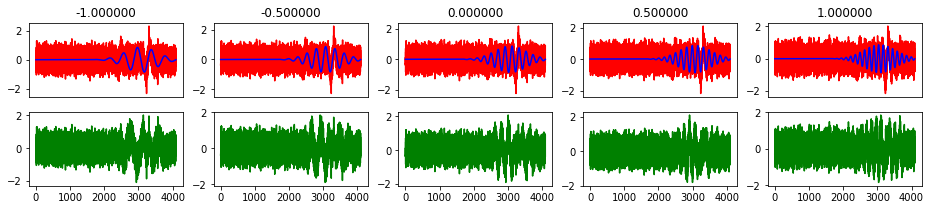

Iter:   50  Loss:      0.000 re=         0 kl=         0  Time:  15.4s
Iter:  100  Loss:      0.000 re=         0 kl=         0  Time:  28.9s
Iter:  150  Loss:      0.000 re=         0 kl=         0  Time:  42.4s
Iter:  200  Loss:      0.000 re=         0 kl=         0  Time:  56.0s
Iter:  250  Loss:      0.000 re=         0 kl=         0  Time:  69.2s
Iter:  300  Loss:      0.000 re=         0 kl=         0  Time:  82.5s
Iter:  350  Loss:      0.000 re=         0 kl=         0  Time:  96.2s
Iter:  400  Loss:      0.000 re=         0 kl=         0  Time: 109.3s


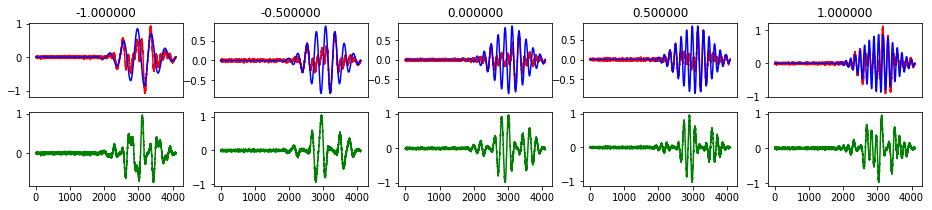

Iter:  450  Loss:      0.000 re=         0 kl=         0  Time: 123.9s
Iter:  500  Loss:      0.000 re=         0 kl=         0  Time: 137.3s
Iter:  550  Loss:      0.000 re=         0 kl=         0  Time: 150.8s
Iter:  600  Loss:      0.000 re=         0 kl=         0  Time: 164.7s
Iter:  650  Loss:      0.000 re=         0 kl=         0  Time: 178.6s
Iter:  700  Loss:      0.000 re=         0 kl=         0  Time: 192.1s
Iter:  750  Loss:      0.000 re=         0 kl=         0  Time: 205.8s
Iter:  800  Loss:      0.000 re=         0 kl=         0  Time: 219.2s


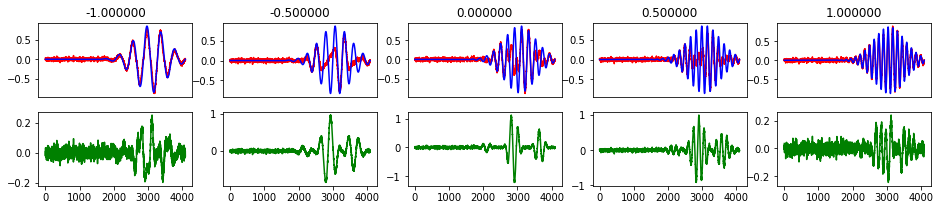

Iter:  850  Loss:      0.000 re=         0 kl=         0  Time: 233.7s
Iter:  900  Loss:      0.000 re=         0 kl=         0  Time: 247.2s
Iter:  950  Loss:      0.000 re=         0 kl=         0  Time: 260.6s
Iter: 1000  Loss:      0.000 re=         0 kl=         0  Time: 273.8s
Iter: 1050  Loss:      0.000 re=         0 kl=         0  Time: 287.6s
Iter: 1100  Loss:      0.000 re=         0 kl=         0  Time: 301.0s
Iter: 1150  Loss:      0.000 re=         0 kl=         0  Time: 314.6s
Iter: 1200  Loss:      0.000 re=         0 kl=         0  Time: 328.2s


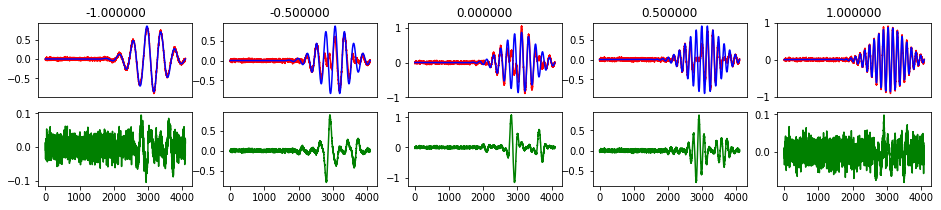

Iter: 1250  Loss:      0.000 re=         0 kl=         0  Time: 342.7s
Model saved in path: /tmp/lin/vae.ckpt


In [126]:
###############
###############   Training
###############
start_time = time.time()

summary_writer = tf.summary.FileWriter("/tmp/lin/.tensorboard/%04d"%COUNTER)
COUNTER = COUNTER+1
LR      = 0.005
batch_size = 50

#saver.restore(sess, "/tmp/lin/vae.ckpt")
#print("Model restored.")
kl=re=0
for epoch in range(1300):

    summ = loss = re = kl = 0
    index = [i for i in range(N)]   
    #random.shuffle(index)
    
    while len(index)>0:
        index_size = len(index)
        batch_index = [index.pop() for _ in range(min(batch_size,index_size))]
        
        #_, loss, re, kl = sess.run([solver, vae_loss, recon_loss, kl_loss], feed_dict={X: Xt[batch_index,:], c: Yt[batch_index,:], lr:LR })
        _,_,_,_, summ = sess.run([solver, mean_loss_op, mean_kl_loss_op, mean_recon_loss_op, merged], feed_dict={X: Xt[batch_index,:], c: Yt[batch_index,:], lr:LR})
        #print (loss, re, kl)

    if TBOARD: summary_writer.add_summary(summ, epoch)
    
    if math.isnan(loss):
        print('Iter: %4d  Loss: %10.3f re=%10g kl=%10g  Time: %5.1fs' % (epoch, loss, re, kl, time.time()-start_time ))
        assert False, "Nan detecteced !"
    if epoch % 50 == 0:
        print('Iter: %4d  Loss: %10.3f re=%10g kl=%10g  Time: %5.1fs' % (epoch, loss, re, kl, time.time()-start_time ))
    if epoch % 400 == 0:
        
        SID = 1*NTYPE
        zz = 0*np.random.randn(NTYPE, z_dim)
        samples = sess.run(X_samples, feed_dict={z: zz, c: np.reshape(Yv[SID:SID+NTYPE],  (NTYPE, 2) ) } )
        
        fig = plt.figure(figsize=(16, 3))
        gs = gridspec.GridSpec(2, NTYPE)
        ##gs.update(wspace=0.2, hspace=0.15)
        for i, sample in enumerate(samples):
            #plt.axis('off')
            ax = plt.subplot(gs[i])
            plt.xticks([], [])
            plt.title("%f" % (Yv[SID+i,0]) )
            plt.plot(sample, 'r')
            plt.plot(Xv[SID+i,:], 'b')

            ax = plt.subplot(gs[i+NTYPE])
            plt.plot(sample-Xv[SID+i,:], 'g')
        plt.show()
        
save_path = saver.save(sess, "/tmp/lin/vae.ckpt")
print("Model saved in path: %s" % save_path)        

<Figure size 432x288 with 0 Axes>

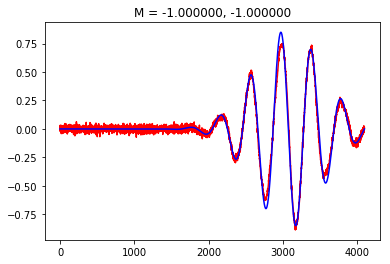

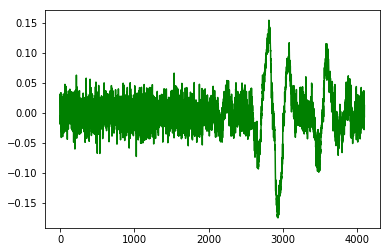

In [107]:

###
###  Test if it can produce an input GW signal
### 
ID = 10

plt.figure()
zz = 0*np.random.randn(1, z_dim)
samples = sess.run(X_samples, feed_dict={z: zz, c: np.reshape(Yt[ID],  (1, 2) ) } )
plt.figure()
plt.title("M = %f, %f" % (Yt[ID,0],Yt[ID,1]) )
plt.plot(samples[0], 'r')
plt.plot(Xt[ID,:], 'b')
plt.show()
plt.plot(samples[0]-Xt[ID,:], 'g')
plt.show()


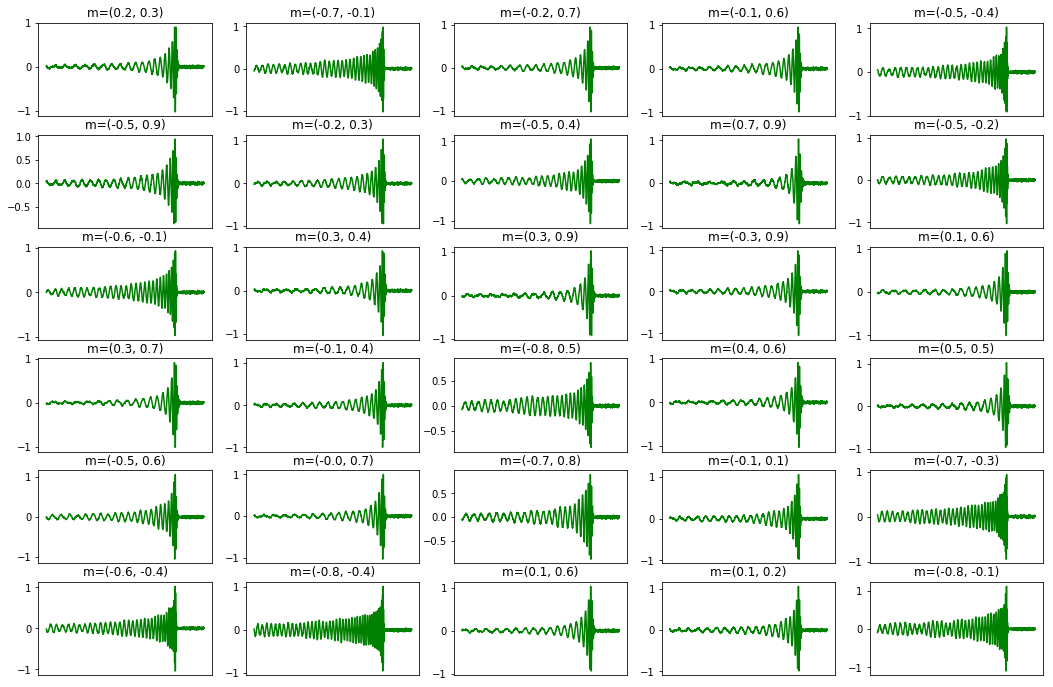

In [181]:
###
###  Test if it can produce many input GW signals
###
import random
test_X = Xt
test_Y = Yt

plt.figure(figsize=(18,12))

ranidx = random.sample(range(len(test_X)), 30)   ## test randomly sample
zz = np.random.randn(30, z_dim)
w1 = sess.run(X_samples, feed_dict={z: zz, c: np.reshape(test_Y[ranidx],  (30, 2) ) } )

for i in range(len(ranidx)):
    plt.subplot(6,5,i+1)         
    plt.title("m=(%.1f, %.1f)"%(test_Y[ranidx[i],0],test_Y[ranidx[i],1]))
    
    #plt.plot(w1[i], 'r')
    #plt.plot(test_X[ranidx[i], 'b')
    plt.plot(test_X[ranidx[i]]-w1[i], 'g')
    plt.xticks([])
   
    if (i > 30): break
plt.show()
    
    
#plt.savefig("VAE_testdiff.png")

            
            
    

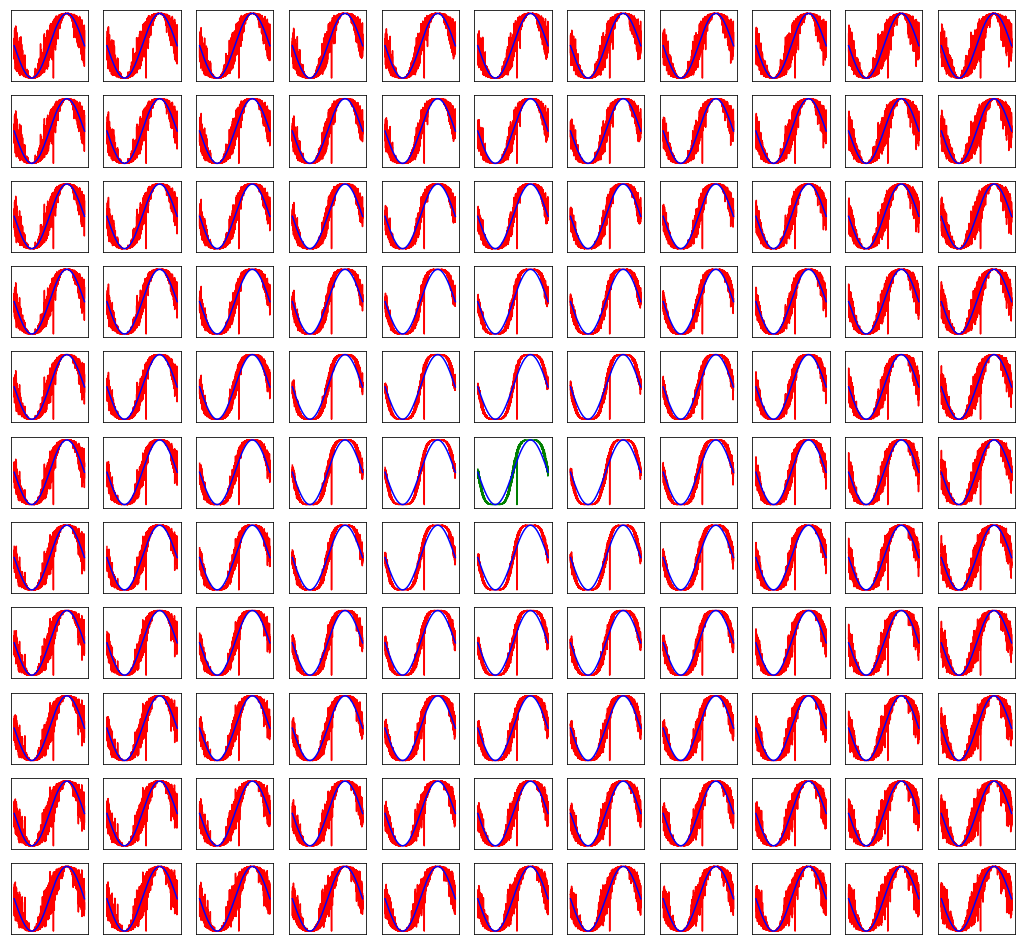

In [186]:
###
###  Draw sample over "2D" latent space
###
import random
plt.figure(figsize=(18,17))

NX=11
NUM=NX*NX
ranidx = random.sample(range(len(Xt)), NUM)   ## test randomly sample

zz = np.zeros([NUM, z_dim])
zz_x = np.linspace(-5,5,NX)
for ix in range(NX):
 for iy in range(NX):
   zz[ix*NX+iy, 0]=zz_x[ix]
   zz[ix*NX+iy, 1]=zz_x[iy]


#y = np.array( [0, np.pi/5.,  np.pi/2.5,  np.pi/1.2, np.pi ]*150 )
ID=3
w1 = sess.run(X_samples, feed_dict={z: zz, c: np.reshape( np.zeros([NUM,2])+np.pi/1.2,  (NUM, 2) ) } )

for i in range(len(ranidx)):
    plt.subplot(NX,NX,i+1)
    #plt.title("m=(%.1f, %.1f)"%(Yt[ranidx[i],0],Yt[ranidx[i],1]))
    
    if (i==NUM/2): plt.plot(w1[i], 'g')
    else:          plt.plot(w1[i], 'r')
    plt.plot(Xt[ID,:], 'b')
    #plt.plot(Xt[ID+1,:], 'b')
    plt.xticks([])
    plt.yticks([])
   
    if (i > NUM): break
plt.show()
    
    
#plt.savefig("VAE_testdiff.png")

            
            
    

In [275]:
####### ================================================ No used
####### 
#######   Reference CVAE code for MNIST
#######


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline


mnist = input_data.read_data_sets('/tmp/MNIST_data', one_hot=True)
mb_size = 64
z_dim = 100
RATE = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]  #m1,m2
h_dim = 128
lr = 1e-3


print ( np.max(mnist.train.images[10]) )
print ( np.min(mnist.train.images[10]) )

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


# =============================== Q(z|X) : proposed encoder ======================================

X = tf.placeholder(tf.float32, shape=[None, RATE])
c = tf.placeholder(tf.float32, shape=[None, y_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

## 
Q_W1 = tf.Variable(xavier_init([RATE + y_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
##
Q_W2_mu    = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu    = tf.Variable(tf.zeros(shape=[z_dim]))
Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, c):
    inputs = tf.concat(axis=1, values=[X, c])
    h = tf.nn.sigmoid(tf.matmul(inputs, Q_W1) + Q_b1)
    z_mu = tf.nn.sigmoid( tf.matmul(h, Q_W2_mu) + Q_b2_mu )
    #z_logvar =  tf.nn.sigmoid( tf.matmul(h, Q_W2_sigma) + Q_b2_sigma )
    z_logvar =  tf.nn.relu( tf.matmul(h, Q_W2_sigma) + Q_b2_sigma )
    return z_mu, z_logvar


def sample_z(mu, log_var):
    #print (mu)
    #print (log_var)
    eps = tf.random_normal(shape=tf.shape(mu))
    
    #return (mu + tf.exp(log_var / 2) * eps)
    return mu + log_var * eps


# =============================== P(X|z) : decoder ======================================

P_W1 = tf.Variable(xavier_init([z_dim + y_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, RATE]))
P_b2 = tf.Variable(tf.zeros(shape=[RATE]))


def P(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    h = tf.nn.relu(tf.matmul(inputs, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    #prob = tf.nn.sigmoid(logits)
    prob = (tf.nn.tanh(logits)+1) /2
    return prob, logits


# =============================== TRAINING ====================================

z_mu, z_logvar = Q(X, c)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample, c)

# Sampling from random z
X_samples, _ = P(z, c)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum( logvar + z_mu**2 - 1. - tf.log(z_logvar), 1)
#kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer(learning_rate=lr).minimize(vae_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(50000):
    X_mb, y_mb = mnist.train.next_batch(mb_size)

    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb, c: y_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()

        y = np.zeros(shape=[16, y_dim])
        y[:, 9] = 1.
        #y[:, np.random.randint(0, y_dim)] = 1.

        zz = np.vstack( ( 0*np.random.randn(4, z_dim), 0.5*np.random.randn(4, z_dim), np.random.randn(4, z_dim), 2*np.random.randn(4, z_dim)   )  )
        samples = sess.run(X_samples,
                           feed_dict={z: zz, c: y})

        print (np.max(samples),np.min(samples))
        fig = plot(samples)
        #plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        plt.show()
        i += 1
        #plt.close(fig)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
0.9960785
0.0


NameError: name 'logvar' is not defined